In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import graph_statistics
import utils
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot, make_rel_error_df, heat_map_from_df)

# NetGAN vs our method

### Statistics used

In [2]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
#                  'Claw Count':graph_statistics.claw_count,
                 'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 'Characteristic Path Length':graph_statistics.compute_cpl,
                 'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count
                 }

### Datasets (original graphs)

In [3]:
original_graphs = {}
datasets = ['CORA-ML', 'citeseer', 'web_edu', 'rt_gop']
# datasets = ['rt_gop']
for name in datasets:
    _A_obs = load_npz(f'../data/datasets/{name}.npz')

    val_share = 0.1
    test_share = 0.05
    seed = 481516234

    train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)
    train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
    
    original_graphs[name] = train_graph

### Make dataframe and heatmap

In [4]:
df = make_rel_error_df(datasets=datasets, 
                       models={'baseline_NetGAN':-1, 'Ours':1}, 
                       statistic_fns=statistic_fns,
                       overlap=0.47,
                       original_graphs=original_graphs)

In [5]:
df

,Assortativity,Clustering Coefficient,Characteristic Path Length,Edge Distribution Entropy,Gini,Max Degree,Power Law α,Spectral Gap,Square Count,Triangle Count,Wedge Count,ROC-AUC Score,Average Precision
CORA-ML,-0.001465,-0.073807,-0.023158,-0.003344,-0.047658,0.064706,-0.013361,0.337986,-0.092893,0.023126,0.012732,0.012432,0.012629
citeseer,1.261483,-0.236641,0.156765,-0.001441,-0.034438,0.111111,-0.010036,4.994949,0.086066,0.527536,0.016674,0.093028,0.084371
web_edu,0.215610,-0.174522,0.253340,0.002787,-0.017527,0.294949,-0.003391,-7.432321,-0.047664,0.015052,0.087475,0.014926,0.014542
rt_gop,-0.113124,NaN,0.040606,-0.018988,-0.061018,-0.118333,-0.110116,-0.452592,-4.525000,NaN,-0.264520,0.033941,0.052882


In [8]:
# utils.save_dict(df, 'df.p')
df = utils.load_dict('df.p')

In [9]:
df = df.rename(index={'CORA-ML':'CORA-ML', 'citeseer':'Citeseer', 'web_edu':'Web-EDU', 'rt_gop':'RT-GOP'},
               columns={'Clustering Coefficient':'Clustering coeff.',
                        'Characteristic Path Length':'Charac. path len.',
                        'Edge Distribution Entropy':'Rel. edge distr. entr.',
                        'Gini':'Gini coeff.',
                        'Max Degree':'Max. degree',
                        'Power Law α':'Power law exp.',
                        'Spectral Gap':'Spectral gap',
                        'Square Count':'Square count',
                        'Triangle Count':'Triangle count',
                        'Wedge Count':'Wedge count',
                        'ROC-AUC Score':'ROC-AUC',
                        'Average Precision':'AP'})
df = df[['Max. degree', 'Assortativity', 'Wedge count', 'Triangle count', 'Square count',
         'Power law exp.', 'Clustering coeff.', 'Spectral gap', 'Charac. path len.', 'Rel. edge distr. entr.',
         'ROC-AUC', 'AP']]
df

,Max. degree,Assortativity,Wedge count,Triangle count,Square count,Power law exp.,Clustering coeff.,Spectral gap,Charac. path len.,Rel. edge distr. entr.,ROC-AUC,AP
CORA-ML,0.064706,-0.001465,0.012732,0.023126,-0.092893,-0.013361,-0.073807,0.337986,-0.023158,-0.003344,0.012432,0.012629
Citeseer,0.111111,1.261483,0.016674,0.527536,0.086066,-0.010036,-0.236641,4.994949,0.156765,-0.001441,0.093028,0.084371
Web-EDU,0.294949,0.215610,0.087475,0.015052,-0.047664,-0.003391,-0.174522,-7.432321,0.253340,0.002787,0.014926,0.014542
RT-GOP,-0.118333,-0.113124,-0.264520,NaN,-4.525000,-0.110116,NaN,-0.452592,0.040606,-0.018988,0.033941,0.052882


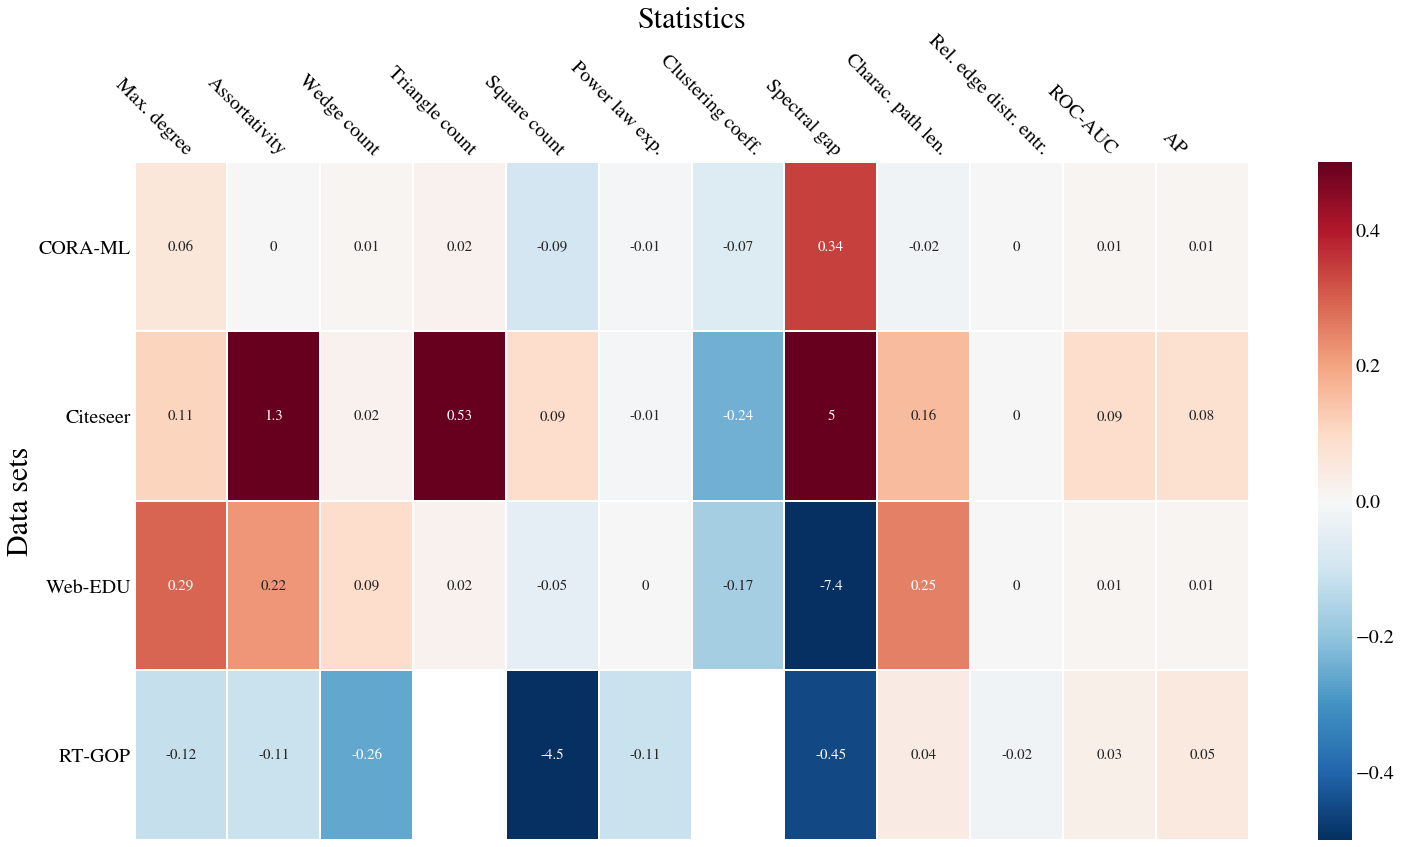

In [10]:
heat_map_from_df(df, figsize=(20, 10), color_limits=(-.5, .5), annot_size=15,
                 xlabel_size=30,
                 ylabel_size=30,
                 xtick_size=20,
                 ytick_size=20,
                 xtick_shift=0.3,
                 colorlabel_size=20,
                 save_path='../fig/rel_error_table.pdf')

# What are the correct overlaps?

In [15]:
import os
def print_overlaps(path):
    avg_overlap = 0
    c = 0
    for experiment in os.listdir(path):
        c += 1
        print(experiment)
        overlap_dict = utils.load_dict(os.path.join(path, experiment, 'sampled_graphs/overlap.pickle'))
        overlap = overlap_dict
        print(overlap)
#         avg_overlap += overlap 
#     avg_overlap /= c
#     print(f'Average overlap: {avg_overlap}')

In [18]:
print_overlaps('../logs/rel_error_table/CORA-ML/Ours/')

Experiment_0
{19: 0.26905499041721953, 38: 0.5298540468819106}
Experiment_1
{19: 0.2656641604010025, 38: 0.5364882795223352}
Experiment_4
{19: 0.27288810260946483, 38: 0.5286746277458352}
Experiment_3
{19: 0.25254312251216277, 38: 0.5208609759693351}
Experiment_2
{19: 0.2590299277605779, 38: 0.5325077399380805}
